In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from bambi import Model, Prior
import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
dat_2005 = pd.read_csv("../data/data_05.csv", index_col=0)
#dat_2007 = pd.read_csv("../data/data_07.csv", index_col=0)
#dat_2009 = pd.read_csv("../data/data_09.csv", index_col=0)
dat_2005.head()

,car_risk_score,age,bmi,bmipct,grade,q12,q13,q15,q16,q17,...,qmarijuanaschool,qnobese,qnowt,qpropertydamage,race4,race7,sex,stheight,stweight,sitecode
122833,166.666667,13.0,22.401235,89.512236,1.0,1.0,1.0,1.0,3.0,1.0,...,1.0,2.0,1.0,1.0,2.0,3.0,2.0,1.80,72.58,CH
122834,0.000000,15.0,29.518950,97.827183,1.0,3.0,1.0,2.0,1.0,1.0,...,1.0,1.0,2.0,2.0,2.0,3.0,2.0,1.96,113.40,CH
122836,222.222222,15.0,19.041156,43.184776,1.0,1.0,1.0,1.0,3.0,4.0,...,1.0,2.0,2.0,3.0,2.0,3.0,2.0,1.78,60.33,CH
122839,333.333333,15.0,19.470395,49.891675,1.0,1.0,1.0,1.0,1.0,3.0,...,1.0,2.0,2.0,1.0,2.0,3.0,2.0,1.78,61.69,CH
122840,0.000000,15.0,22.045828,78.873273,1.0,1.0,1.0,1.0,1.0,3.0,...,1.0,2.0,2.0,1.0,4.0,7.0,2.0,1.78,69.85,CH


In [4]:
#generate sample from data just for testing
dat_2005 = dat_2005.sample(2000, random_state=551)
dat_2005["car_risk_score"] = dat_2005["car_risk_score"] + 1
county_idxs, counties = pd.factorize(dat_2005["sitecode"]) # needed for hierarchical model
coords = {
    "county": counties,
    "obs_id": np.arange(len(county_idxs)),
}

In [19]:
with pm.Model(coords=coords) as model:  # model specifications in PyMC3 are wrapped in a with-statement
    
    county_idx = pm.Data("county_idx", county_idxs, dims="obs_id")

    # Define priors
    #sigma = pm.Gamma("sigma", alpha=.01, beta=.01)
    intercept = pm.Normal("Intercept", 0, sigma=.001, dims="county")
    X = dat_2005.drop(["car_risk_score", "sitecode"], axis=1)
    #beta = pm.Normal("beta", 1, sigma=10, shape=X.shape[1])
    question_betas = []
    for i, q in enumerate(X.columns):
        q_beta = pm.Normal("beta" + str(i), 1, sigma=10, dims="county")
        question_betas.append(q_beta)
    mu_est = intercept[county_idx]
    for i, b in enumerate(question_betas):
        mu_est += b[county_idx] * X.iloc[:,i]

    # Define likelihood
    likelihood = pm.Gamma(
        "y",
        #mu=intercept[county_idx] + pm.math.dot(X, beta),
        alpha=mu_est,
        beta=100,
        observed=dat_2005["car_risk_score"], dims="obs_id")
    #print(pm.distributions.shape_utils.to_tuple(likelihood.shape))
    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    #trace = pm.sample(3000, return_inferencedata=True)

    #pm.sample_posterior_predictive(trace, var_names=["x"])

In [20]:
with model:
    trace = pm.sample(100, return_inferencedata=True, target_accept=0.9)
    ppc = pm.sample_posterior_predictive(trace, var_names=["y"])

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta41, beta40, beta39, beta38, beta37, beta36, beta35, beta34, beta33, beta32, beta31, beta30, beta29, beta28, beta27, beta26, beta25, beta24, beta23, beta22, beta21, beta20, beta19, beta18, beta17, beta16, beta15, beta14, beta13, beta12, beta11, beta10, beta9, beta8, beta7, beta6, beta5, beta4, beta3, beta2, beta1, beta0, Intercept]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 556 seconds.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


In [32]:
with model:
    approx = pm.fit()

Finished [100%]: Average Loss = 1.4949e+05


In [36]:
approx.sample()[0]

{'Intercept': array([-0.13405697, -0.18237783, -0.14235681,  0.09245967,  0.14445425,
         0.19990115,  0.03192565, -0.0008244 , -0.15781145, -0.18578878,
         0.06339932, -0.02972709, -0.06359579, -0.06780464,  0.19846251,
         0.09505527]),
 'beta0': array([ 0.20024427,  1.20507486,  1.21321424, -0.06818118,  0.84404835,
        -0.06933231, -0.00689128,  0.48389195,  0.56684952,  1.10896461,
         0.61909059,  0.48430989, -0.1224021 , -0.0837237 ,  0.01228873,
         0.49009857]),
 'beta1': array([ 0.29002871,  0.14457296,  0.34643901,  0.8036162 ,  0.21543769,
        -0.2177284 ,  0.31566113,  0.50675479,  0.62560964,  0.68077638,
         0.62775988,  0.15136493,  0.16846578, -0.44586303, -0.64952099,
         0.52997242]),
 'beta2': array([ 0.11414546, -0.08135413,  0.03261023,  0.25478063,  0.60589281,
         0.17721207,  0.11852158,  0.52342399,  0.48514975,  0.13783932,
         0.38415431,  0.59320019, -0.03290921, -0.09275824,  0.10870191,
        -0.0822

Model Checking using extreme risk scores

In [10]:
threshold = 500
y_pred = ppc["y"].ravel()
(y_pred > threshold).sum() / y_pred.shape[0] * 100

0.8106333333333333

In [11]:
(d["car_risk_score"] > threshold).sum() / d.shape[0] * 100

5.35

Posteriors

In [13]:
trace["posterior"]["beta"].mean(axis=1).mean(axis=0)

<xarray.DataArray 'beta' (beta_dim_0: 42)>
array([ 0.04193462,  2.21147322, -0.12590578, -4.44222118,  0.04580159,
        0.84422828, -2.17199115,  1.89782359,  1.87158427, -2.8352238 ,
       -1.51948074,  1.27821781,  4.06445621, -2.49474252,  2.86567833,
        3.96155926,  1.35426137, -0.15945564,  2.7444114 , -1.36986351,
        4.81179482, -5.60435428,  1.40885847, -6.64042714,  2.09663982,
        1.53048519,  0.78630122,  0.08926084, -0.60183046,  1.03730451,
       -4.63797695, -2.94037446, -3.09766493, -2.96920986,  8.95169639,
        5.88946865, -0.09959246,  1.6969421 , -0.82686616,  0.63526875,
        7.59657035, -0.2195706 ])
Coordinates:
  * beta_dim_0  (beta_dim_0) int64 0 1 2 3 4 5 6 7 8 ... 34 35 36 37 38 39 40 41

In [30]:
ppc

{'y': array([[6.15338258e+01, 2.65132678e-08, 4.58644277e-02, ...,
         2.57793881e+02, 8.86695514e-01, 3.68170897e+00],
        [1.95312259e+02, 2.56040777e+02, 7.79994016e-02, ...,
         1.46988487e+02, 2.34895084e+01, 4.16819282e-01],
        [3.06129017e+02, 1.99876836e+01, 1.58422021e-05, ...,
         7.59159444e+00, 2.02663529e+01, 5.44587289e+00],
        ...,
        [5.04086002e+02, 8.41621650e+01, 1.47229782e+01, ...,
         9.40602794e+01, 6.56257355e+01, 1.33946004e-35],
        [2.57183710e+01, 6.96138978e-12, 4.67791407e+02, ...,
         1.40305160e+02, 4.02212749e+01, 6.48357753e+01],
        [6.84474996e+01, 3.79664942e+01, 4.80828329e-05, ...,
         7.31520511e+01, 3.67922417e+00, 8.38387943e-06]])}

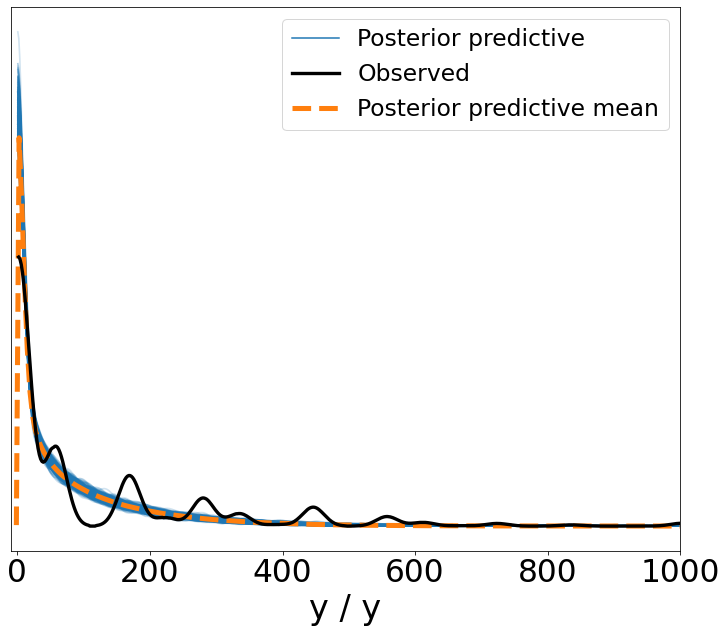

In [29]:
ax = az.plot_ppc(
    az.from_pymc3(posterior_predictive=ppc, model=model), figsize=(12, 10))
_ = ax.set_xlim((-10, 1000))

In [31]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

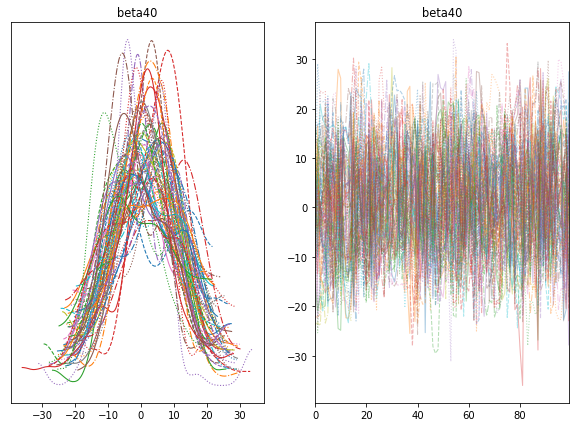

In [28]:
_ = az.plot_trace(trace["posterior"]["beta40"][:,:,], figsize=(10, 7))